In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter
import matplotlib.pyplot as plt
import umap
import matplotlib
import mygene
%matplotlib inline
import pickle
import sklearn
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
# import sentence_transformers
plt.style.use('ggplot')
#plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [25]:
from src.utils import download_file, setup_data_dir

setup_data_dir()

File already exists at /Users/rj/personal/GenePT/data/GenePT_emebdding_v2.zip
Extracting files...
Extracting GenePT_emebdding_v2/
Skipping GenePT_emebdding_v2/NCBI_UniProt_summary_of_genes.json - already exists with same size
Skipping GenePT_emebdding_v2/GenePT_gene_embedding_ada_text.pickle - already exists with same size
Skipping GenePT_emebdding_v2/GenePT_gene_protein_embedding_model_3_text.pickle. - already exists with same size
Skipping GenePT_emebdding_v2/NCBI_summary_of_genes.json - already exists with same size
Extraction complete!
Setup finished!


In [6]:
embedding_dir = data_dir / "GenePT_emebdding_v2"
ada_embedding_path = embedding_dir / "GenePT_gene_embedding_ada_text.pickle"
large_embedding_path = embedding_dir / "GenePT_gene_embedding_ada_text.pickle"

print("embedding_dir exists:", embedding_dir.exists())
print("ada_embedding_path exists:", ada_embedding_path.exists())
print("large_embedding_path exists:", large_embedding_path.exists())


embedding_dir exists: True
ada_embedding_path exists: True
large_embedding_path exists: True


In [7]:
from src.utils import get_gene_embeddings
# gene_embedding = get_gene_embeddings("text-embedding-ada-002")
gene_embedding = get_gene_embeddings("text-embedding-3-large")

In [8]:
# Create random embeddings as negative controls
np.random.seed(2023)
N_DIM = 1536
fake_pretrain_embed = dict()
for key in gene_embedding.keys():
    fake_pretrain_embed[key] = np.random.normal(size=(N_DIM))

### Long- vs short- range TFs

The input data used here are downloaded from Chen et al. (2020) (link: https://www-nature-com.stanford.idm.oclc.org/articles/s41467-020-16106-x).

Data link: https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-16106-x/MediaObjects/41467_2020_16106_MOESM4_ESM.csv



In [9]:
# Create moesm directory if it doesn't exist
moesm_dir = data_dir / "moesm"
moesm_dir.mkdir(exist_ok=True)

# Download URL for the TF data
tf_data_url = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-020-16106-x/MediaObjects/41467_2020_16106_MOESM4_ESM.csv"
tf_csv_path = download_file(tf_data_url)



File already exists at /Users/rj/personal/GenePT/data/41467_2020_16106_MOESM4_ESM.csv


In [10]:
long_short_range_tf = pd.read_csv(tf_csv_path)
long_range_tf_gene = list(long_short_range_tf[long_short_range_tf['assignment']=='long-range TF']\
                                ['Unnamed: 0'])
short_range_tf_gene = list(long_short_range_tf[long_short_range_tf['assignment']=='short-range TF']\
                                ['Unnamed: 0'])
x_long_range_tf = [gene_embedding[x] for x in long_range_tf_gene \
               if x in gene_embedding]
x_short_range_tf =  [gene_embedding[x] for x in short_range_tf_gene\
               if x in gene_embedding]

In [11]:
# bivalent versus non-methylated
np.random.seed(2023)
random.seed(2023)

# Assuming x and y are your data
# For demonstration, let's create some dummy data.
# Ensure your data is in NumPy array format for compatibility
X_array = np.concatenate((x_long_range_tf,x_short_range_tf))
y_array = np.concatenate((np.repeat(1,len(x_long_range_tf)),np.repeat(0,len(x_short_range_tf))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.743 +/- 0.137
Random Forest ROC AUC: 0.856 +/- 0.135


## Dosage sensitive vs insensitive TFs

In [12]:
# Create data directory for dosage sensitivity data if it doesn't exist
dosage_dir = data_dir / "dosage_sensitivity"
dosage_dir.mkdir(exist_ok=True)

# Download URL for the dosage sensitivity data
dosage_data_url = "https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/resolve/main/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sensitivity_TFs.pickle"
dosage_pickle_path = download_file(dosage_data_url)

# Load the pickle file
with open(dosage_pickle_path, "rb") as f:
    dosage_data = pickle.load(f)

# Extract sensitive and insensitive TFs
sensitive = dosage_data["Dosage-sensitive TFs"]
insensitive = dosage_data["Dosage-insensitive TFs"]

File already exists at /Users/rj/personal/GenePT/data/dosage_sensitivity_TFs.pickle


In [13]:
mg = mygene.MyGeneInfo()
sensitive_query = mg.querymany(sensitive, species='human')
in_sensitive_query = mg.querymany(insensitive, species='human')
sensitive_gene_name = [x['symbol'] for x in sensitive_query]
in_sensitive_gene_name = [x['symbol'] for x in in_sensitive_query if 'symbol' in x]

1 input query terms found no hit:	['ENSG00000215271']


In [14]:
x_sensitive = [gene_embedding[name] for name in sensitive_gene_name\
               if name in gene_embedding]
x_insensitive = [gene_embedding[name] for name in in_sensitive_gene_name \
                 if name in gene_embedding]
x_dosage = x_sensitive.copy()
x_dosage.extend(x_insensitive)
y_dosage = np.concatenate((np.repeat(1,len(x_sensitive)),np.repeat(0,len(x_insensitive))))

In [15]:
np.random.seed(2023)
random.seed(2023)

# Ensure your data is in NumPy array format for compatibility
X_array = np.array(x_dosage)
y_array = np.array(y_dosage)


# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.874 +/- 0.044
Random Forest ROC AUC: 0.892 +/- 0.038


# Plot ROC curve for logistic regression and random forest models

This might require latex installation.  On Mac, you can install it with:
```
brew install --cask mactex
```

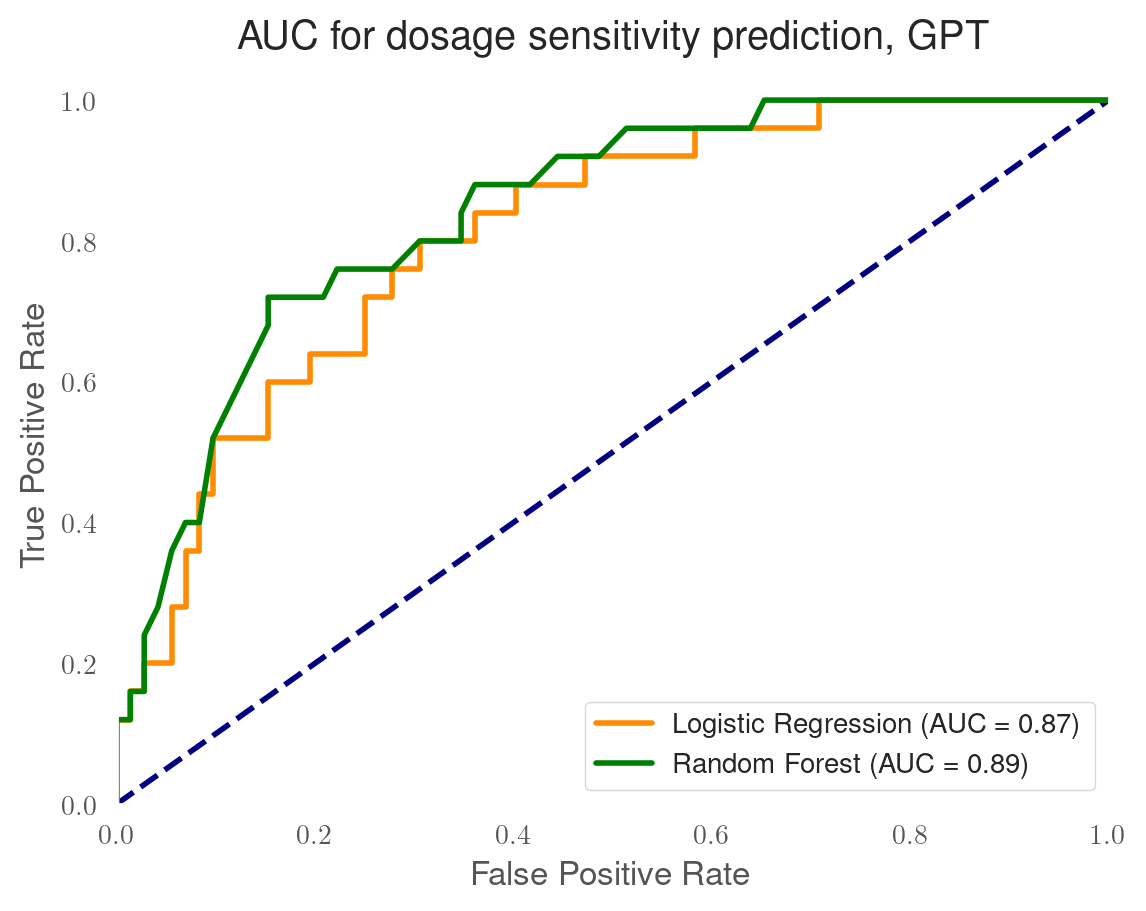

In [16]:
# Plot ROC curves
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_logistic[0], tpr_logistic[0], color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % np.mean(roc_auc_logistic))
plt.plot(fpr_rf[0], tpr_rf[0], color='green', lw=2, label='Random Forest (AUC = %0.2f)' % np.mean(roc_auc_rf))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC for dosage sensitivity prediction, GPT')
plt.legend(loc='lower right')
plt.show()

## Methylation state prediction
The Methylation state prediction files are downloaded from https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/

In [22]:
bivalent_vs_no_methyl_data_url = "https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/resolve/main/example_input_files/gene_classification/bivalent_promoters/bivalent_vs_no_methyl.pickle"
bivalent_vs_no_methyl_data_path = download_file(bivalent_vs_no_methyl_data_url)
with open(bivalent_vs_no_methyl_data_path, "rb") as f:
    bivalent_vs_no_methyl_data = pickle.load(f)

bivalent_vs_lys4_only_data_url = "https://huggingface.co/datasets/ctheodoris/Genecorpus-30M/resolve/main/example_input_files/gene_classification/bivalent_promoters/bivalent_vs_lys4_only.pickle"
bivalent_vs_lys4_only_data_path = download_file(bivalent_vs_lys4_only_data_url)
with open(bivalent_vs_lys4_only_data_path, "rb") as f:
    bivalent_vs_lys4_only_data = pickle.load(f)


File already exists at /Users/rj/personal/GenePT/data/bivalent_vs_no_methyl.pickle
File already exists at /Users/rj/personal/GenePT/data/bivalent_vs_lys4_only.pickle


In [23]:
bivalent_query = mg.querymany(bivalent_vs_no_methyl_data['bivalent'], species='human')
no_methylation_query = mg.querymany(bivalent_vs_no_methyl_data['no_methylation'], species='human')
lysine_query = mg.querymany(bivalent_vs_lys4_only_data['lys4_only'], species='human')

10 input query terms found dup hits:	[('ENSG00000007372', 2), ('ENSG00000110693', 2), ('ENSG00000117707', 2), ('ENSG00000120093', 2), ('E
2 input query terms found dup hits:	[('ENSG00000147488', 2), ('ENSG00000151322', 2)]
2 input query terms found dup hits:	[('ENSG00000196628', 2), ('ENSG00000198728', 2)]


In [24]:

x_bivalent = [gene_embedding[x['symbol']] for x in bivalent_query\
               if 'symbol' in x and x['symbol'] in gene_embedding]
x_no_methylation = [gene_embedding[x['symbol']] for x in no_methylation_query\
               if 'symbol' in x and  x['symbol'] in gene_embedding]
x_lysine = [gene_embedding[x['symbol']] for x in lysine_query\
                if 'symbol' in x and  x['symbol'] in gene_embedding]


### Bivalent versus non-methylated

In [20]:
# bivalent versus non-methylated
np.random.seed(2023)
random.seed(2023)

X_array = np.concatenate((x_bivalent,x_no_methylation))
y_array =  np.concatenate((np.repeat(1,len(x_bivalent)),np.repeat(0,len(x_no_methylation))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)

# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")


Logistic Regression ROC AUC: 0.905 +/- 0.051
Random Forest ROC AUC: 0.914 +/- 0.073


### bivalent versus lys-4 methylated

In [21]:
np.random.seed(2023)
random.seed(2023)

# Assuming x and y are your data
# For demonstration, let's create some dummy data.
# Ensure your data is in NumPy array format for compatibility
X_array = np.concatenate((x_bivalent,x_lysine))
y_array =  np.concatenate((np.repeat(1,len(x_bivalent)),np.repeat(0,len(x_lysine))))

# Set up Stratified K-Folds cross-validator
# It provides train/test indices to split data into train/test sets
cv = StratifiedKFold(n_splits=5)

# Lists to store ROC AUC scores for each fold
roc_auc_logistic = []
roc_auc_rf = []
roc_auc_xgb = []

# Lists to store TPR and FPR for each fold
tpr_logistic = []
fpr_logistic = []
tpr_rf = []
fpr_rf = []

for train_index, test_index in cv.split(X_array, y_array):
    X_train, X_test = X_array[train_index], X_array[test_index]
    y_train, y_test = y_array[train_index], y_array[test_index]

    # Logistic Regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    y_score_logistic = logistic_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_logistic)
    roc_auc = auc(fpr, tpr)
    roc_auc_logistic.append(roc_auc)
    tpr_logistic.append(tpr)
    fpr_logistic.append(fpr)

    # Random Forest
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(X_train, y_train)
    y_score_rf = random_forest_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score_rf)
    roc_auc = auc(fpr, tpr)
    roc_auc_rf.append(roc_auc)
    tpr_rf.append(tpr)
    fpr_rf.append(fpr)


# Print ROC AUC scores
print(f"Logistic Regression ROC AUC: {np.mean(roc_auc_logistic):.3f} +/- {np.std(roc_auc_logistic):.3f}")
print(f"Random Forest ROC AUC: {np.mean(roc_auc_rf):.3f} +/- {np.std(roc_auc_rf):.3f}")

Logistic Regression ROC AUC: 0.946 +/- 0.035
Random Forest ROC AUC: 0.949 +/- 0.040
